In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [67]:
import sys
sys.path.append('../')

import jax.numpy as jnp
import matplotlib.pyplot as plt

from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.networks import ScoreNet
from sdebridge.utils import plot_est_vector_field

plt.style.use('ggplot')

In [78]:
model = DiffusionBridge(
    drift=lambda x, t: 0.0 * jnp.ones(2),
    diffusion=lambda x, t: jnp.array([[1.0, 0.0], [0.0, 1.0]]),     
    dim=2,
    end_time=1.0,
    num_steps=50,
    true_score_transition=lambda x, x0, t: -(x - x0) / t,
    true_score_h=lambda x, xT, t, T: -(x - xT) / (T - t),
)

(32, 51, 2)


Text(0.5, 1.0, 'Forward Brownian Motion Trajectories')

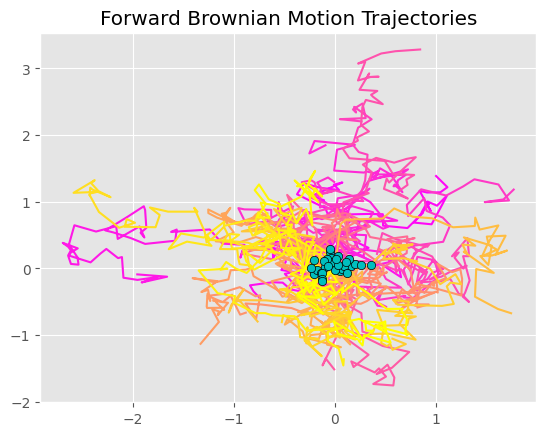

In [69]:
forward_brownian_motion_trajectories = model.simulate_forward_process(initial_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)))
print(forward_brownian_motion_trajectories.shape)
colormap = plt.get_cmap("spring")
colors = [colormap(i) for i in jnp.linspace(0, 1, forward_brownian_motion_trajectories.shape[0])]
for i in range(forward_brownian_motion_trajectories.shape[0]):
    plt.plot(forward_brownian_motion_trajectories[i, :, 0], forward_brownian_motion_trajectories[i, :, 1], color=colors[i], zorder=1)
    plt.scatter(forward_brownian_motion_trajectories[i, 1, 0], forward_brownian_motion_trajectories[i, 1, 1], color='c', edgecolor='k', zorder=2)
plt.title("Forward Brownian Motion Trajectories")

In [79]:
train_params = {"batch_size": 32, "num_epochs": 20, "num_batches_per_epoch": 50, "learning_rate": 5e-3}
score_transition_net = ScoreNet(out_dim=model.d,
                                time_embedding_dim=64,
                                embedding_dim=64,
                                act='leaky_relu',
                                encoder_layer_dims=[64, 64],
                                decoder_layer_dims=[64, 64],
                                using_batchnorm=False)
score_transition_state = model.learn_forward_transition_score(score_transition_net, 
                                                              initial_condition=jnp.array([0.0, 0.0]), 
                                                              training_params=train_params)

Epoch 1 / 20: loss = 45.7848
Epoch 2 / 20: loss = 44.9190
Epoch 3 / 20: loss = 44.9506
Epoch 4 / 20: loss = 44.7903
Epoch 5 / 20: loss = 44.8853
Epoch 6 / 20: loss = 44.9655
Epoch 7 / 20: loss = 44.4816
Epoch 8 / 20: loss = 44.9205
Epoch 9 / 20: loss = 45.0512
Epoch 10 / 20: loss = 44.8714
Epoch 11 / 20: loss = 44.5124
Epoch 12 / 20: loss = 44.9365
Epoch 13 / 20: loss = 44.5999
Epoch 14 / 20: loss = 44.7762
Epoch 15 / 20: loss = 44.7310
Epoch 16 / 20: loss = 44.8326
Epoch 17 / 20: loss = 44.8476
Epoch 18 / 20: loss = 44.7617
Epoch 19 / 20: loss = 44.8067
Epoch 20 / 20: loss = 44.6726


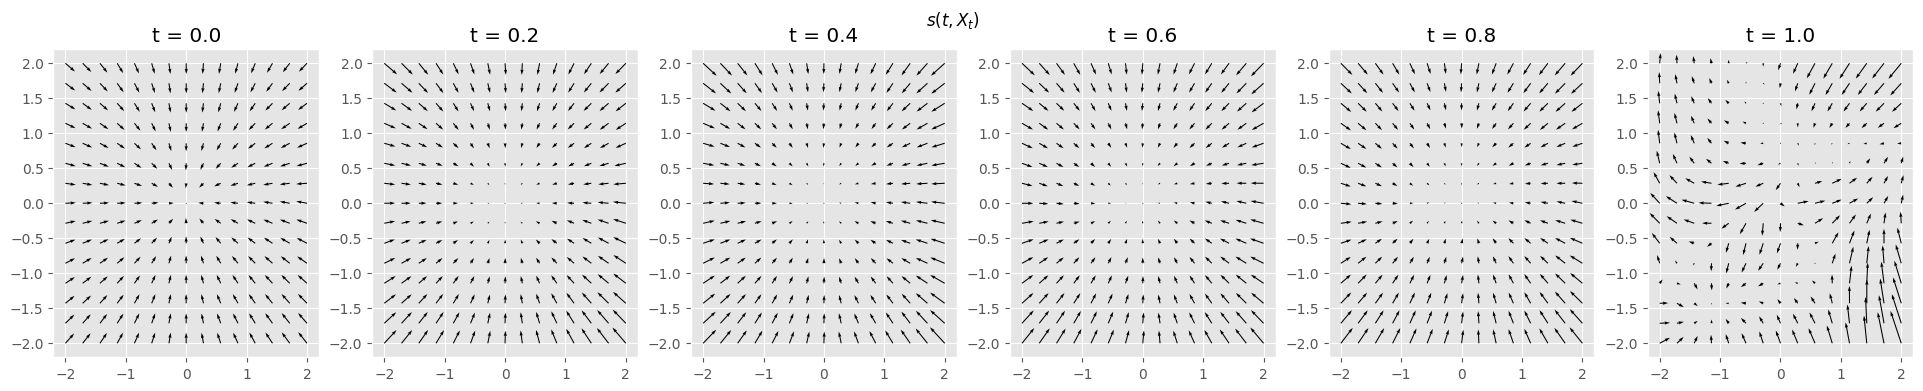

In [80]:
plot_est_vector_field(X_est_state=score_transition_state,
                      xs=jnp.linspace(-2.0, 2.0, 15),
                      ts=jnp.linspace(0., 1., 5+1),
                      suptitle=r"$s(t, X_t)$",
                      scale=None)

(32, 51, 2)


Text(0.5, 1.0, 'Backward Brownian Bridge Trajectories')

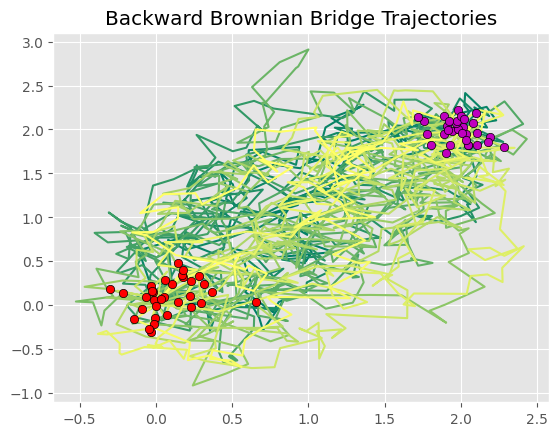

In [81]:
backward_brownian_bridge_trajectories = model.simulate_backward_bridge(score_transition_state=score_transition_state, 
                                                                       initial_condition=jnp.tile(jnp.array([[2.0, 2.0]]), reps=(32, 1)), 
                                                                       terminal_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                                       using_true_score=False)
print(backward_brownian_bridge_trajectories.shape)
colormap = plt.get_cmap("summer")
colors = [colormap(i) for i in jnp.linspace(0, 1, backward_brownian_bridge_trajectories.shape[0])]
for i in range(backward_brownian_bridge_trajectories.shape[0]):
    plt.plot(backward_brownian_bridge_trajectories[i, :, 0], backward_brownian_bridge_trajectories[i, :, 1], color=colors[i], zorder=1)
    plt.scatter(backward_brownian_bridge_trajectories[i, 1, 0], backward_brownian_bridge_trajectories[i, 1, 1], color='r', edgecolor='k', zorder=2)
    plt.scatter(backward_brownian_bridge_trajectories[i, -2, 0], backward_brownian_bridge_trajectories[i, -2, 1], color='m', edgecolor='k', zorder=2)
plt.title("Backward Brownian Bridge Trajectories")

In [82]:
train_params = {"batch_size": 32, "num_epochs": 20, "num_batches_per_epoch": 20, "learning_rate": 1e-3}
score_marginal_net = ScoreNet(out_dim=model.d,
                                time_embedding_dim=64,
                                embedding_dim=64,
                                act='leaky_relu',
                                encoder_layer_dims=[64, 64],
                                decoder_layer_dims=[64, 64],
                                using_batchnorm=False)
score_marginal_state = model.learn_marginal_score(score_marginal_net=score_marginal_net,
                                                   initial_condition=jnp.array([2.0, 2.0]),
                                                   terminal_condition=jnp.array([0.0, 0.0]),
                                                   score_transition_state=score_transition_state,
                                                   training_params=train_params)

Epoch 1 / 20: loss = 55.8199
Epoch 2 / 20: loss = 52.8914
Epoch 3 / 20: loss = 52.1855
Epoch 4 / 20: loss = 51.9551
Epoch 5 / 20: loss = 51.6773
Epoch 6 / 20: loss = 51.3988
Epoch 7 / 20: loss = 50.7322
Epoch 8 / 20: loss = 50.9817
Epoch 9 / 20: loss = 50.8058
Epoch 10 / 20: loss = 50.8398
Epoch 11 / 20: loss = 50.6291
Epoch 12 / 20: loss = 50.2922
Epoch 13 / 20: loss = 50.4164
Epoch 14 / 20: loss = 50.3379
Epoch 15 / 20: loss = 50.0533
Epoch 16 / 20: loss = 49.8546
Epoch 17 / 20: loss = 50.0484
Epoch 18 / 20: loss = 50.0834
Epoch 19 / 20: loss = 50.6301
Epoch 20 / 20: loss = 49.4538


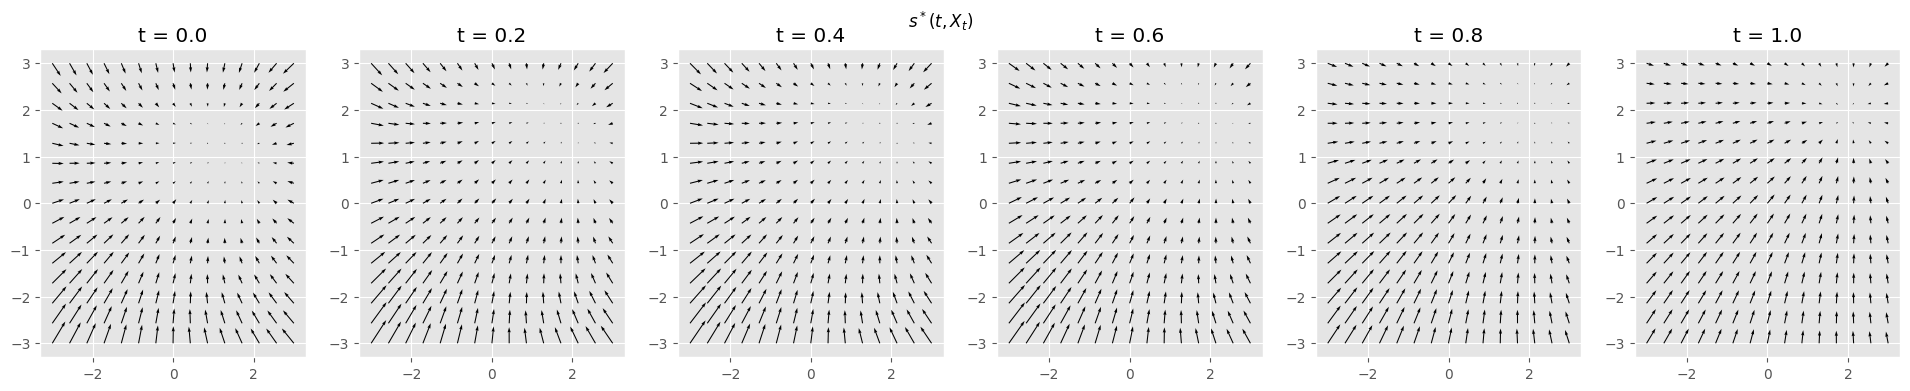

In [83]:
plot_est_vector_field(score_marginal_state,
                      xs=jnp.linspace(-3.0, 3.0, 15),
                      ts=jnp.linspace(0., 1., 5+1),
                      suptitle=r"$s^*(t, X_t)$",
                      scale=None)

(32, 51, 2)


Text(0.5, 1.0, 'Forward Brownian Bridge Trajectories')

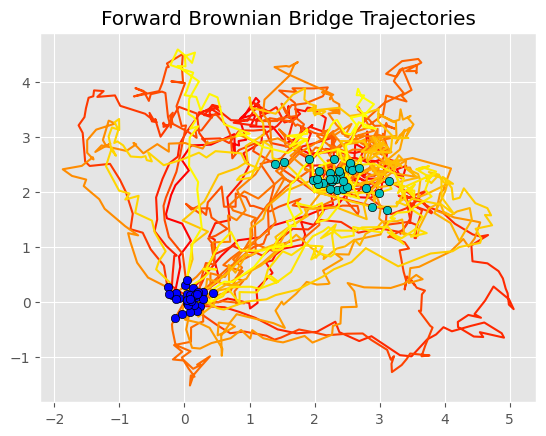

In [84]:
forward_brownian_bridge_trajectories = model.simulate_forward_bridge(score_transition_state=score_transition_state, 
                                                                     score_marginal_state=score_marginal_state,
                                                                     initial_condition=jnp.tile(jnp.array([[0.0, 0.0]]), reps=(32, 1)), 
                                                                     terminal_condition=jnp.tile(jnp.array([[2.0, 2.0]]), reps=(32, 1)), 
                                                                     using_true_score=False)
print(forward_brownian_bridge_trajectories.shape)
colormap = plt.get_cmap("autumn")
colors = [colormap(i) for i in jnp.linspace(0, 1, forward_brownian_bridge_trajectories.shape[0])]
for i in range(forward_brownian_bridge_trajectories.shape[0]):
    plt.plot(forward_brownian_bridge_trajectories[i, :, 0], forward_brownian_bridge_trajectories[i, :, 1], color=colors[i], zorder=1)
    plt.scatter(forward_brownian_bridge_trajectories[i, 1, 0], forward_brownian_bridge_trajectories[i, 1, 1], color='b', edgecolor='k', zorder=2)
    plt.scatter(forward_brownian_bridge_trajectories[i, -2, 0], forward_brownian_bridge_trajectories[i, -2, 1], color='c', edgecolor='k', zorder=2)
plt.title("Forward Brownian Bridge Trajectories")